In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

In [2]:
# Set some parameters to apply to all plots. These can be overridden
# in each plot if desired
import matplotlib
# Plot size to 14" x 7"
# matplotlib.rc('figure', figsize = (14, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set background color to white
matplotlib.rc('axes', facecolor = 'white')

In [3]:
os.chdir('Documents/repos/geo')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'arcgis.ipynb',
 'choropleth-map-example.png',
 'create_da_table.ipynb',
 'create_xy_table.ipynb',
 'data',
 'geo_doodle.py',
 'img',
 'my_functions_geo.py',
 'new_workflow.ipynb',
 'parking_Toronto.ipynb',
 'README.md',
 'Teranet_data_cleaning.ipynb',
 'Teranet_GTHA_DA_investigating_pins.ipynb',
 'Teranet_GTHA_DA_spatial_join.ipynb',
 'Teranet_GTHA_DA_workflow.ipynb',
 'Teranet_GTHA_GIS_no_nan.png',
 'Teranet_GTHA_GIS_with_nan.png',
 'Teranet_meeting_May24_2019.pptx',
 '__pycache__']

# Create xy-level table from Teranet data

This notebook describes the creation process for a DataFrame (table) with xy-level data derived from Teranet records.

Proposed schema of the xy-level table:

<img src='img/xy_table_scheme.HEIC'></img>
<img src='img/xy_table_scheme.png'></img>

## Load cleaned Teranet dataset with `da_in` column
`da_id` column was produced via a spatial join between Teranet points and DA polygons
(for details, see notebook `Teranet_GTHA_DA_spatial_join.ipynb`)

In [4]:
# column `pin` will be converted to dtype=category
# after records with NaN `consideration_amt` will be dropped
dtypes = {
    'decade': 'int',
    'year': 'int',
    'lro_num': 'category',
    'postal_code': 'category',
    'street_designation': 'category',
    'street_direction': 'category',
    'municipality': 'category',
    'da_id': 'category',
    'da_city': 'category',
}
drop_cols = ['Unnamed: 0', 'index', 
             'index_right', 'province',
             'street_suffix']
t = time.time()
teranet_path = 'data/HHSaleHistory_cleaned_v0.9_GTHA_DA.csv'
df = pd.read_csv(teranet_path, 
                 parse_dates=['registration_date'],
                 dtype=dtypes)
df = df.drop(drop_cols, axis=1)
elapsed = time.time() - t
print("----- DataFrame with Teranet records loaded in "
      "{0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with Teranet records loaded in 36.78 seconds
with 6,062,853 rows
and 18 columns
-- Column names:
 Index(['registration_date', 'decade', 'year', 'lro_num', 'pin',
       'consideration_amt', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'da_id', 'da_city', 'da_median_tot_inc'],
      dtype='object')


In [5]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6062853 entries, 0 to 6062852
Data columns (total 18 columns):
registration_date     6062853 non-null datetime64[ns]
decade                6062853 non-null int32
year                  6062853 non-null int32
lro_num               6062853 non-null category
pin                   6062853 non-null int64
consideration_amt     4637584 non-null float64
postal_code           5534039 non-null category
unitno                1339242 non-null float64
street_name           5874264 non-null object
street_designation    5516855 non-null category
street_direction      520896 non-null category
municipality          6058942 non-null category
street_number         5870282 non-null float64
x                     6062853 non-null float64
y                     6062853 non-null float64
da_id                 6062853 non-null category
da_city               6062853 non-null category
da_median_tot_inc     6021553 non-null float64
dtypes: category(7), datetime64[ns]

### Drop all records with missing (or <$30) `consideration_amt` 

In [6]:
df = df.dropna(subset=['consideration_amt'])
df['pin'] = df['pin'].astype('category')
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4637584 entries, 2 to 6062850
Data columns (total 18 columns):
registration_date     4637584 non-null datetime64[ns]
decade                4637584 non-null int32
year                  4637584 non-null int32
lro_num               4637584 non-null category
pin                   4637584 non-null category
consideration_amt     4637584 non-null float64
postal_code           4342478 non-null category
unitno                1140626 non-null float64
street_name           4588439 non-null object
street_designation    4327098 non-null category
street_direction      424608 non-null category
municipality          4635981 non-null category
street_number         4587129 non-null float64
x                     4637584 non-null float64
y                     4637584 non-null float64
da_id                 4637584 non-null category
da_city               4637584 non-null category
da_median_tot_inc     4608506 non-null float64
dtypes: category(8), datetime64[

### Unique records by `pin`
Column `pin` can be used for grouping operations with Teranet data.

In [7]:
df['pin'].describe()

count       4637584
unique      2219927
top       211080033
freq            464
Name: pin, dtype: int64

### Unique records by `xy`
Column `xy` is produced by concatenating `x` and `y` coordinates as strings. It can be used for grouping operations with Teranet data.

In [8]:
df['xy'] = df['x'].astype('str') + df['y'].astype('str')
df['xy'].describe()

count                                 4637584
unique                                1394189
top       -79.413759934962343.776162782863395
freq                                     7222
Name: xy, dtype: object

There is a significant discrepancy between the number of records with unique `pin` and the number of records with unique `xy` (# with same `xy` > # with same `pin`).

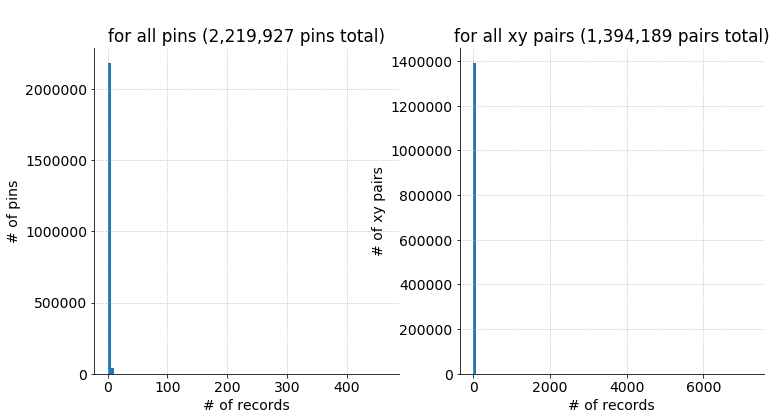

In [12]:
pin_counts = df['pin'].value_counts()
xy_counts = df['xy'].value_counts()

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.title("Histogram of records")

pin_counts.hist(bins=100, ax=axes[0])
axes[0].set_title("\nfor all pins ({0:,} pins total)"
                  .format(len(pin_counts)))
axes[0].set_ylabel("# of pins")
axes[0].set_xlabel("# of records")
axes[0].grid(linestyle=':')

xy_counts.hist(bins=100, ax=axes[1])
axes[1].set_title("\nfor all xy pairs ({0:,} pairs total)"
                  .format(len(xy_counts)))
axes[1].set_ylabel("# of xy pairs")
axes[1].set_xlabel("# of records")
axes[1].grid(linestyle=':')

plt.show()

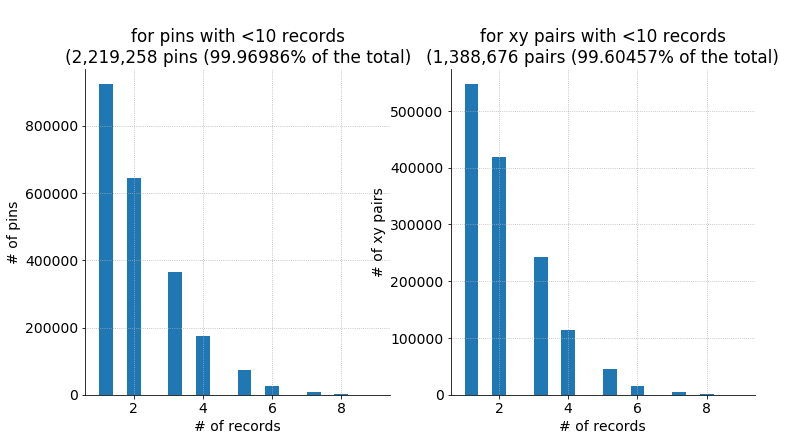

In [13]:
max_counts = 10

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.title("Histogram of records")

pin_counts[pin_counts < max_counts].hist(bins=20, 
                                         ax=axes[0])
axes[0].set_title("for pins with <{0} records"
                  .format(max_counts) + 
                  "\n({0:,} pins ({1:.5f}% of the total)"
          .format(len(pin_counts[pin_counts < max_counts]),
                  len(pin_counts[pin_counts < max_counts])
                            / len(pin_counts) * 100))
axes[0].set_ylabel("# of pins")
axes[0].set_xlabel("# of records")
axes[0].grid(linestyle=':')

xy_counts[xy_counts < max_counts].hist(bins=20, 
                                       ax=axes[1])
axes[1].set_title("\nfor xy pairs with <{0} records"
                  .format(max_counts) + 
            "\n({0:,} pairs ({1:.5f}% of the total)"
                  .format(len(xy_counts[xy_counts < max_counts]),
                  len(xy_counts[xy_counts < max_counts])
                          / len(xy_counts) * 100))
plt.ylabel("# of xy pairs")
plt.xlabel("# of records")
plt.grid(linestyle=':')

## Aggregate records by `pin`

### Add column `total_sales_pin`
Total records for each pin, generated as a separate DataFrame `df_pin` which represents Teranet records grouped and indexed by `pin`.

`total_sales_pin` is added as a new column for Teranet records via a merge operation on `pin`.

In [14]:
# create a new DataFrame with daily aggregates per customer
col_rename = {'registration_date': 'total_sales_pin'}

df_pin = \
    df.groupby(['pin'])['registration_date'].count()\
        .reset_index().rename(columns=col_rename)
df_pin['pin'].describe()

# join a new column to the original DataFrame
df = pd.merge(df,
              df_pin,
              left_on=['pin'],
              right_on=['pin'],
              how='left')
print("New column 'total_sales_pin' added to the DataFrame!")

New column 'total_sales_pin' added to the DataFrame!


### Add column `prev_sales_pin`
A new column is added to Teranet records capturing, for each transaction, a rolling count of previous records from this `pin`.

In [17]:
t = time.time()
# add column 'prev_visits' to DataFrame with daily data
df['prev_sales_pin'] = \
    df.groupby('pin')['registration_date']\
        .transform(lambda x: x.expanding().count())\
        .astype('int') - 1 # current sale is not counted
elapsed = time.time() - t
print("New column 'prev_sales_pin' added to the DataFrame!"
      "\ntook {0:.2f} seconds.".format(elapsed))

KeyboardInterrupt: 